In [9]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display
import datetime
import threading
import logging
import time
import itertools
import smtplib
from email.mime.text import MIMEText
from collections import Counter
import csv
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os

In [10]:
# constants
ONLINE = True
root_location = r'C:\Users\opben\OneDrive\Documents\Esh Release Radar'
model_tracks_playlist_id = '1N3g2lFG8fW3W7ecyQTD07'
prediction_tracks_playlist_id = '5kwIeMf9pQVCMwpSo2on55'
features_to_use = ["duration_ms","acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo","valence"]

In [73]:
# Spotify utils

client_id = "YOUR_CLIENT_ID_HERE"
client_secret = "YOUR_CLIENT_SECRET_HERE"
redirect_uri = "http://localhost:9999/callback"
scope = "playlist-modify-private"

def get_all_playlist_track_details(sp,playlist_id):
    def add_features(playlist_tracks):
        tracks = [pt['track'] for pt in playlist_tracks]
        track_features = sp.audio_features([t["id"] for t in tracks])
        return list(zip(tracks,track_features))
    results = sp.playlist_tracks(playlist_id)
    collected_tracks = add_features(results['items'])
    while results['next']:
        results = sp.next(results)
        collected_tracks.extend(add_features(results['items']))
    track_details_list = []
    for track,features in collected_tracks:
        details = dict()
        details["id"]=track["id"]
        details["name"]=track["name"]
        details["album_id"]=track["album"]["id"]
        details["album_name"]=track["album"]["name"]
        details["artist_id"]=track["artists"][0]["id"]
        details["artist_name"]=track["artists"][0]["name"]
        if not features: continue
        for f in features_to_use:
            details[f] = features[f]
        details["duration_ms"]=track["duration_ms"]
        track_details_list.append(details)
    return track_details_list

def export_to_csv(name,data):
    with open(os.path.join(root_location,'%s_data.csv' % name),'w',newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, data[0].keys())
        dict_writer.writeheader()
        dict_writer.writerows(data)
              
def import_from_csv(name):
    with open(os.path.join(root_location,'%s_data.csv' % name),'r',newline='') as data_file:
        return list(csv.DictReader(data_file))

def dict_list_to_dataframe(dicts):
    return pd.DataFrame(dicts,columns=dicts[0].keys())

def evaluate_model(model,model_data,model_targets,model_name):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(model_data,model_targets,random_state=0)
    model.fit(X_train, y_train)
    print("Model: %s" % model_name)
    print("Training set score: {:.2f}".format(model.score(X_train,y_train)))
    print("Test set score: {:.2f}".format(model.score(X_test,y_test)))

In [89]:
# Retrieve data
if ONLINE:
    # Get data from spotify
    sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope,client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri))
    model_tracks = get_all_playlist_track_details(sp,model_tracks_playlist_id)
    prediction_tracks = get_all_playlist_track_details(sp,prediction_tracks_playlist_id)
    export_to_csv('model',model_tracks)
    export_to_csv('prediction',prediction_tracks)
else:
    model_tracks = import_from_csv('model')
    prediction_tracks = import_from_csv('prediciton')
model_tracks_df = dict_list_to_dataframe(model_tracks)
prediction_tracks_df = dict_list_to_dataframe(prediction_tracks)

In [75]:
# Split to data and target
metallica_or_madonna_tracks = model_tracks_df[model_tracks_df.artist_name.isin(["Metallica","Madonna"])]
X = metallica_or_madonna_tracks[features_to_use].astype(float)
y = pd.get_dummies(metallica_or_madonna_tracks["artist_name"])["Madonna"]

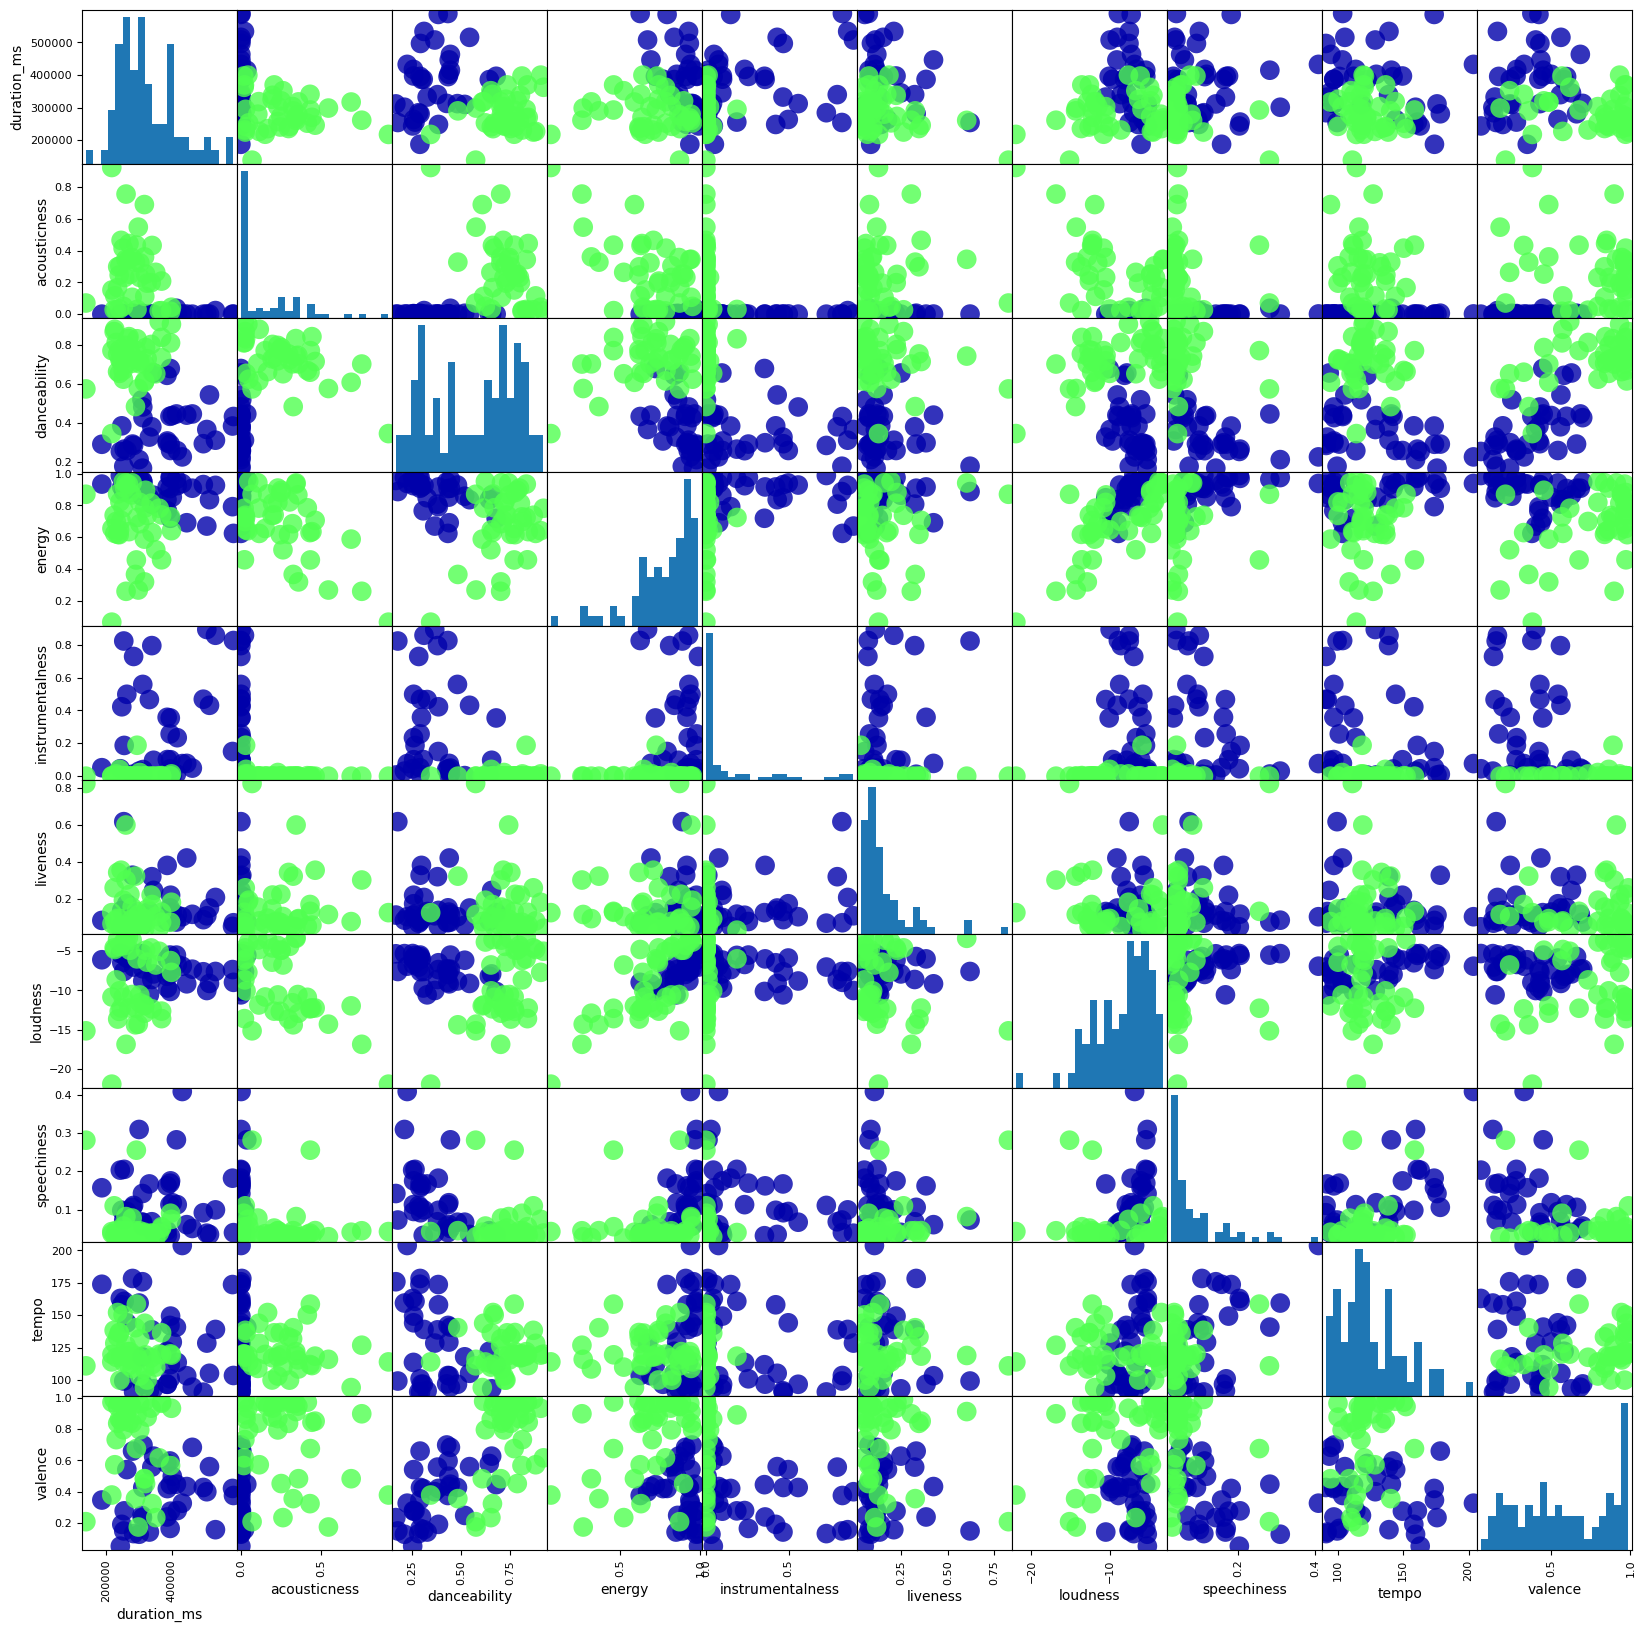

In [99]:
# Plot a 2d scatter matrix
pd.plotting.scatter_matrix(X,c=y,figsize=(20,20),marker='o',hist_kwds={'bins':20},s=200,alpha=.8,cmap=mglearn.cm3)
plt.show()

In [ ]:
# Find uncorrelated features

In [82]:
# Evaluating different models
# Try KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
evaluate_model(knn,X,y,"knn(1)")


from sklearn.linear_model import LinearRegression
linear = LinearRegression()
evaluate_model(linear,X,y,"linear")


from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)
evaluate_model(dtree,X,y,"decision tree")

Model: knn(1)
Training set score: 1.00
Test set score: 0.79
Model: linear
Training set score: 0.89
Test set score: 0.63
Model: decision tree
Training set score: 1.00
Test set score: 1.00


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [92]:
prediction = dtree.predict(prediction_tracks_df[features_to_use])
prediction_tracks_df["artist_predicted"] = np.vectorize(lambda p:["Metallica","Madonna"][p])(prediction)
prediction_tracks_abbrv = prediction_tracks_df[["artist_name","name","album_name","artist_predicted"]]
prediction_tracks_abbrv = prediction_tracks_abbrv.loc[~(prediction_tracks_df["artist_name"] == prediction_tracks_df["artist_predicted"])]
display(prediction_tracks_abbrv)

,artist_name,name,album_name,artist_predicted
11,Madonna,Vogue - Edit,I'm Breathless,Metallica
19,Metallica,Nothing Else Matters,Metallica,Madonna


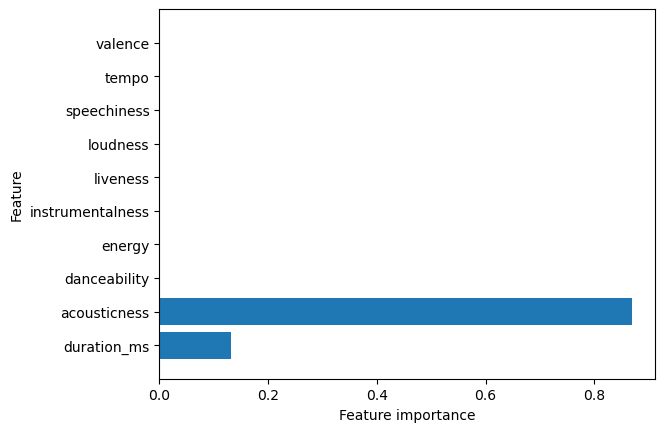

In [98]:
def plot_feature_importances(data,model):
    n_features = data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features_to_use)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(X,dtree)

In [94]:
# Visualize the decision tree
from sklearn.tree import export_graphviz
graph_file = os.path.join(root_location,"tree.dot")
export_graphviz(dtree, out_file=graph_file, class_names=["Metallica", "Madonna"],
                feature_names=features_to_use, impurity=False, filled=True)
import graphviz
with open(graph_file) as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

ModuleNotFoundError: No module named 'graphviz'